# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 3 is due March 5th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime as dt
from scipy.special import expit


<hr style="height:2pt">

### Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

##### **A1**

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

In [3]:
#your code here

train = pd.read_csv('data/dataset_2_train.csv')
test = pd.read_csv('data/dataset_2_test.csv')

train.loc[train.district==61,'district'] = 54
test.loc[test.district==61,'district'] = 54

train.loc[train.district==60,'district'] = 0
test.loc[test.district==60,'district'] = 0

display(train.head())
display(train.describe())

print("\nTraining data size = {}\n".format(train.shape))
print("\nTesting data size = {}\n".format(test.shape))

display(test.head())
display(test.describe())


,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0


,district,urban,living.children,age_mean,contraceptive_use
count,967.000000,967.000000,967.000000,967.000000,967.000000
mean,28.707342,0.307135,2.591520,-0.310626,0.389866
std,17.408268,0.461545,1.248457,8.995747,0.487972
min,0.000000,0.000000,1.000000,-13.560000,0.000000
25%,14.000000,0.000000,1.000000,-7.560000,0.000000
50%,29.000000,0.000000,3.000000,-1.559900,0.000000
75%,45.000000,1.000000,4.000000,6.440000,1.000000
max,59.000000,1.000000,4.000000,19.440000,1.000000



Training data size = (967, 5)


Testing data size = (967, 5)



,district,urban,living.children,age_mean,contraceptive_use
0,1,1,4,18.4400,0
1,1,1,1,-5.5599,0
2,1,1,4,8.4400,0
3,1,1,2,-5.5599,0
4,1,1,4,1.4400,0


,district,urban,living.children,age_mean,contraceptive_use
count,967.000000,967.000000,967.000000,967.000000,967.000000
mean,27.710445,0.274043,2.712513,0.315022,0.395036
std,17.876646,0.446262,1.234460,9.024514,0.489111
min,0.000000,0.000000,1.000000,-13.560000,0.000000
25%,13.000000,0.000000,1.000000,-7.059950,0.000000
50%,28.000000,0.000000,3.000000,-0.559900,0.000000
75%,44.000000,1.000000,4.000000,7.440000,1.000000
max,59.000000,1.000000,4.000000,19.440000,1.000000


# Analysis

<div style="border: 1px solid red; padding: 10px"> 

***Observations about the data-set:***
* Data is equally divided into training set and test set with 967 data-points each
* Data has 5 features:
    - **district:** Categorical factor representing the district the woman hails from; 60 different districts in total
    - **urban:** Binary categorical factor representing whether the woman hails from urban {1} or rural {0} area. 30%/27% of the woman in training/test data were living in urgan area.
    - **living.children:** Qunatitative factor representing the number of childern a woman has; ranges from minimum of 1 and maximum of 4. Average number of living childern are 2.59/2.71 in training/test data.
    - **age_mean:** Normalized age of the woman; mean age in training and test data are different but taking into account the standard deviation, the gap is minor.
    - **contraceptive_use:** Binary categorical variable representing whether the women is using contraceptive or not. Roughly 39% of the women in training and test data are using contraceptives.

##### **A2**

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:  
$\mu_0 = 2$

$\sigma^2_0 = 1$

$\beta_{0j} \sim N(\mu_0,\sigma_0^2)$ for all sixty districts

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

In [4]:
#your code here

# setting seed for replication
np.random.seed(109)

# hard-coding of parameters
j = train.district.nunique() # number of Beta_0's
mu_0 = 2
sigma_0 = 1
beta_1 = 4
beta_2 = -3
beta_3 = -2

# generate beta_0
Beta_0 = np.random.normal(mu_0, sigma_0, j) 
print("\nBeta_0:\n{}\n".format(Beta_0))

# Generate simulated data
simulated_df = train.copy()
simulated_df['contraceptive_use'] = np.random.binomial(1, expit(Beta_0[simulated_df['district']] + 
                                                                beta_1*simulated_df['urban'] + 
                                                                beta_2*simulated_df['living.children'] + 
                                                                beta_3*simulated_df['age_mean']
                                                               ))

# visual inspection of simulated data
display(simulated_df.head())
display(simulated_df.describe())

# compute average contraceptive use
prop = simulated_df['contraceptive_use'].mean()*100
print ("\nProportion of women using contraceptives = \t{0:.2f}%\n".format(prop))


Beta_0:
[1.81226506 4.44063677 1.05909216 2.61391165 2.73562667 2.97291789
 2.25919495 1.92592508 1.82231198 1.16125645 1.84371288 1.65823837
 2.81873029 1.90738606 2.50808094 0.2457775  1.63518202 1.96908145
 1.87385573 2.299181   3.82207405 3.41717686 1.54268378 2.86019957
 2.28468256 2.51062749 3.57829456 2.16130871 2.71819658 1.19400416
 1.40181919 3.32383635 3.13726714 1.51166981 2.34806743 1.02913865
 1.78786357 2.42335106 2.10377004 2.05097481 1.32855935 2.27170251
 2.00701349 2.32662299 2.03618145 0.80672159 1.84189829 2.01341776
 1.52765319 1.79189355 3.44154411 0.32890473 2.54455933 3.26132175
 2.96283701 1.72009832 1.76955224 2.45213427 1.64578923 2.34015305]



,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,0
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0


,district,urban,living.children,age_mean,contraceptive_use
count,967.000000,967.000000,967.000000,967.000000,967.000000
mean,28.707342,0.307135,2.591520,-0.310626,0.476732
std,17.408268,0.461545,1.248457,8.995747,0.499717
min,0.000000,0.000000,1.000000,-13.560000,0.000000
25%,14.000000,0.000000,1.000000,-7.560000,0.000000
50%,29.000000,0.000000,3.000000,-1.559900,0.000000
75%,45.000000,1.000000,4.000000,6.440000,1.000000
max,59.000000,1.000000,4.000000,19.440000,1.000000



Proportion of women using contraceptives = 	47.67%



# Analysis

<div style="border: 1px solid red; padding: 10px"> 

***Process describing data simulation:***
* Generate $60$ values of $\beta_{0,j}$ for $j \in 0 ... 59$ using ```np.random.normal```
* Copy the traning dataset to a new dataframe; make a deep copy
* Calculate $p_i$ as ```expit``` of $\beta_{0,j=district}+\beta_{1}*urban_{i}+\beta_{2}*living.children_{i}+\beta_{3}*age\_mean_{i}$ 
* Simulate $contraceptive\_use_{i}$ as $\ Bernoulli(p_i)\ $ using ```np.random.binomial```
* Compute the mean of simulated $contraceptive\_use$ column to determine what proportion of women use contraceptives

**We find that ```47.67%``` of the women use contraceptives in sumlated data**

##### **A3**

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

Note: It is wise to take advantage of a model's built-in `summary` method to inspect it after fitting

In [5]:
#your code here

# setting seed for replication
np.random.seed(109)

# MCMC Simulation
model = pm.Model()
with model:
    # prior
    mu_0 = pm.Normal('$\mu_0$', mu=0, sd=100)
    sigma_0_sq = pm.InverseGamma('$\sigma_0^{2}$', 0.1, 0.1)
    z = pm.Normal('z', mu=0, sd=1, shape=j)
    beta_0 = pm.Deterministic('$\\beta_0$', mu_0 + z*(sigma_0_sq**0.5))
    beta_1 = pm.Normal('$\\beta_1$', mu=0, sd=100)
    beta_2 = pm.Normal('$\\beta_2$', mu=0, sd=100)
    beta_3 = pm.Normal('$\\beta_3$', mu=0, sd=100)

    # alpha for the given district
    alpha = beta_0[simulated_df['district'].values]
    
    # likelihood
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(alpha +
                                                     (beta_1 * simulated_df['urban']) + 
                                                     (beta_2 * simulated_df['living.children']) + 
                                                     (beta_3 * simulated_df['age_mean'])
                                                    ))

    obs = pm.Bernoulli(name='c_use', p=p_i, observed=simulated_df['contraceptive_use'])
    trace = pm.sample(4000, tune=4000, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$\beta_3$, $\beta_2$, $\beta_1$, z, $\sigma_0^{2}$, $\mu_0$]
Sampling 2 chains, 0 divergences: 100%|██████████| 16000/16000 [11:42<00:00, 22.79draws/s]


In [6]:
# display the summary
display(pm.summary(trace, var_names=['$\mu_0$', '$\sigma_0^{2}$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$']))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
$\mu_0$,0.484,1.038,-1.543,2.411,0.011,0.011,9211.0,4253.0,9295.0,5458.0,1.0
$\sigma_0^{2}$,1.153,1.496,0.019,3.672,0.033,0.023,2078.0,2078.0,2404.0,3112.0,1.0
$\beta_1$,5.295,1.210,3.175,7.619,0.021,0.016,3393.0,2919.0,4041.0,2927.0,1.0
$\beta_2$,-3.209,0.703,-4.510,-1.954,0.013,0.010,3030.0,2670.0,3638.0,2992.0,1.0
$\beta_3$,-2.756,0.530,-3.780,-1.866,0.010,0.008,2780.0,2482.0,3388.0,2943.0,1.0


# Analysis

<div style="border: 1px solid red; padding: 10px"> 

Coefficient   |True Value|Recovered (mean)|94% credible interval
--------------|----------|----------------|---------------------
$\mu_0$       |2         |0.478           |-1.416 to  2.414
$\sigma_0^{2}$|1         |1.166           |0.019 to 3.3605
$\beta_1$     |4         |5.327           |3.196 to 7.638
$\beta_2$     |-3        |-3.216          |-4.553 to -2.023
$\beta_3$     |-2        |-2.764          |-3.748 to -1.851

***Important Comment:***
* I have used ```pm.InverseGamma``` instead of ```pm.Gamma```
* This helps directly work with $\sigma_0^{2}$ rather than $\tau_0$
* Also this avoids the problem of $Harmonic\ Mean$ versus $Airthmetic\ Mean$
     - When using ```pm.Gamma```, we reciver the mean value of $\tau_0 = 0.25$ whereas in-case of ```pm.InverseGamma``` we recover mean value of $\sigma_0^{2} = 1.166$
     - Other recovered values are mostly similar in case of ```pm.InverseGamma``` versus ```pm.Gamma```
     
***Observations:***
* True parameter values lie within the 94% credible interval
* Recovered mean parameter values are reasonably close in case of $\sigma_0^{2}$, $\beta_2$ and $\beta_3$
* Recovered mean parameter values for $\mu_0$ and $\beta_1$ are soemwhat off, but still within 94% credible interval

##### **A4**

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \sigma_0, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

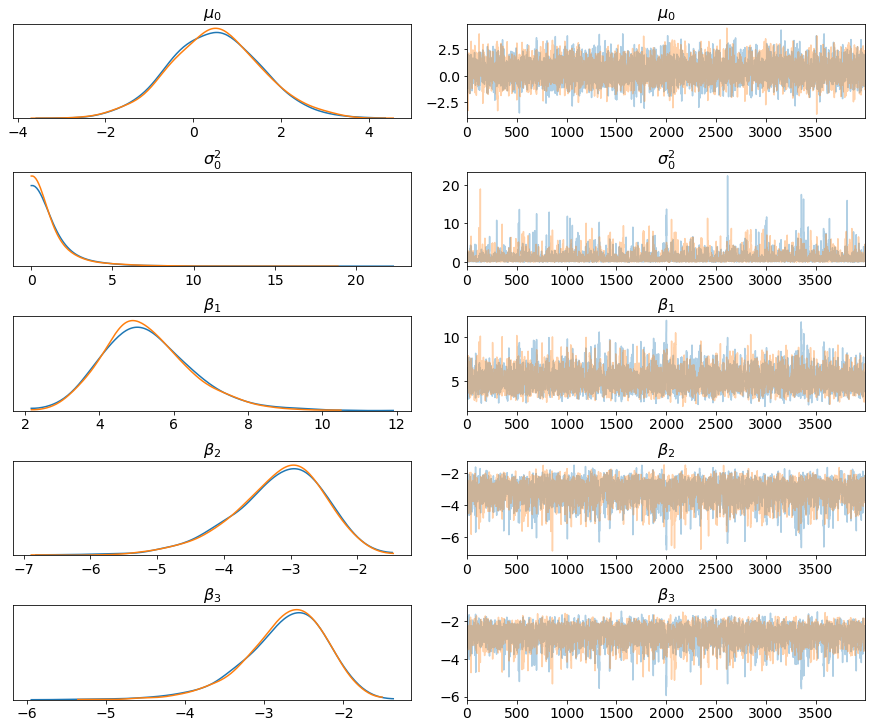

In [7]:
#your code here

import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)
    
    # plot the traceplot
    pm.traceplot(trace, 
                 var_names=['$\mu_0$', '$\sigma_0^{2}$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$'], 
                 compact=False)
    plt.show()

# Analysis

<div style="border: 1px solid red; padding: 10px"> 

Coefficient   |True Value|Recovered (mean)|94% credible interval|$\hat{r}$
--------------|----------|----------------|---------------------|-------
$\mu_0$       |2         |0.478           |-1.416 to  2.414     |1.0
$\sigma_0^{2}$|1         |1.166           |0.019 to 3.3605      |1.0
$\beta_1$     |4         |5.327           |3.196 to 7.638       |1.0
$\beta_2$     |-3        |-3.216          |-4.553 to -2.023     |1.0
$\beta_3$     |-2        |-2.764          |-3.748 to -1.851     |1.0

***Observation on Convergence of Paramenters:***
* $\hat{r}$ value for all the parameters is equal to $1$.
* **From the visual inspection of the graph and the $\hat{r}$ values we can comfortably say that the samplers did converge.**

##### **A5**

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 


Beta_0's for comparison = 

			[1.16125645 2.299181   1.19400416]



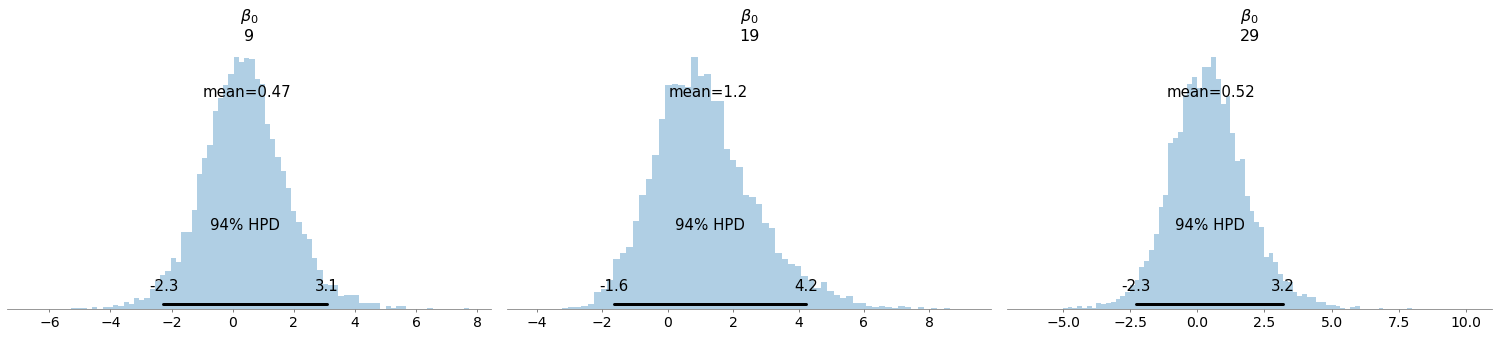


Beta_0's for comparison = 

			[2.05097481 1.79189355 2.34015305]



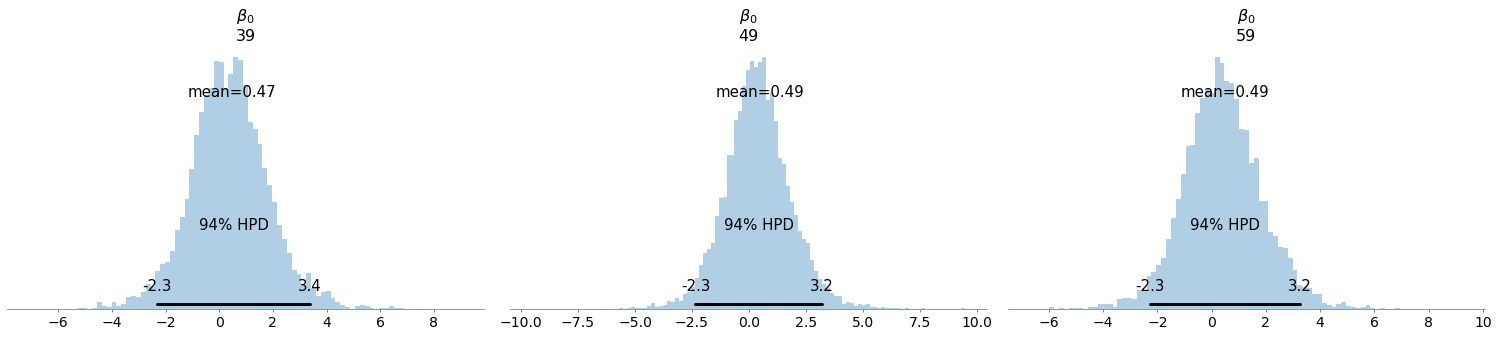

In [8]:
#your code here

# plot the posterior distributions of beta's
print("\nBeta_0's for comparison = \n\n\t\t\t{}\n".format(Beta_0[9:39:10]))
pm.plots.plot_posterior(trace, 
                        var_names=['$\\beta_0$'], kind='hist', 
                        coords={'$\\beta_0$_dim_0':np.arange(9,39,10)})
plt.show()

print("\nBeta_0's for comparison = \n\n\t\t\t{}\n".format(Beta_0[39::10]))
pm.plots.plot_posterior(trace, 
                        var_names=['$\\beta_0$'], kind='hist', 
                        coords={'$\\beta_0$_dim_0':np.arange(39,69,10)})
plt.show()

# Analysis

<div style="border: 1px solid red; padding: 10px"> 

Coefficient   |True Value|Recovered (mean)|Lower Bound|Upper Bound
--------------|----------|----------------|-----------|-----------
$\beta_{0,09}$|1.16125645|0.45            |-2.1       |3.2
$\beta_{0,19}$|2.29918100|1.30            |-1.6       |4.3
$\beta_{0,29}$|1.19400416|0.52            |-2.2       |3.3
$\beta_{0,39}$|2.05097481|0.47            |-2.3       |3.3
$\beta_{0,49}$|1.79189355|0.49            |-2.5       |3.2
$\beta_{0,59}$|2.34015305|0.48            |-2.3       |3.3

***Observation on the Posterior Distributions vs True Parameters:***
* Mean recovered values are not close to the true parameter values
* **However, all the true values are within the credible intervals of the respective posterior distribution**

##### **A6**

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [9]:
#your code here

# setting seed for replication
np.random.seed(109)

# MCMC Simulation
model = pm.Model()
with model:
    # prior
    mu_0 = pm.Normal('$\mu_0$', mu=0, sd=100)
    sigma_0_sq = pm.InverseGamma('$\sigma_0^{2}$', 0.1, 0.1)
    z = pm.Normal('z', mu=0, sd=1, shape=j)
    beta_0 = pm.Deterministic('$\\beta_0$', mu_0 + z*(sigma_0_sq**0.5))
    beta_1 = pm.Normal('$\\beta_1$', mu=0, sd=100)
    beta_2 = pm.Normal('$\\beta_2$', mu=0, sd=100)
    beta_3 = pm.Normal('$\\beta_3$', mu=0, sd=100)

    # alpha  for the given district
    alpha = beta_0[train['district'].values]
    
    # likelihood
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(alpha +
                                                     (beta_1 * train['urban']) + 
                                                     (beta_2 * train['living.children']) + 
                                                     (beta_3 * train['age_mean'])
                                                    ))

    obs = pm.Bernoulli(name='c_use', p=p_i, observed=train['contraceptive_use'])
    trace = pm.sample(4000, tune=4000, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$\beta_3$, $\beta_2$, $\beta_1$, z, $\sigma_0^{2}$, $\mu_0$]
Sampling 2 chains, 0 divergences: 100%|██████████| 16000/16000 [02:11<00:00, 121.55draws/s]


# Analysis

<div style="border: 1px solid red; padding: 10px"> 

***Comments about the model hyperparameters:***
* I used ```pm.InverseGamma``` insted of ```pm.Gamma``` so as to directly work with $\sigma_0^{2}$ instead of $\tau_0$
* Used the following hyperparameters:
    - Sample size of: 4000
    - Tuning Parameter: 4000
    - Target Accept Prob: 0.9
    - Number of Chains: 4
* I also reparameterized my model to help solve divergence issues
    - ```z = pm.Normal('z', mu=0, sd=1, shape=j)```
    - ```beta_0 = pm.Deterministic('$\\beta_0$', mu_0 + z*(sigma_0_sq**0.5))```

##### **A7**

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

In [10]:
#your code here

# display the trace summary
display(pm.summary(trace, var_names=['$\mu_0$', '$\sigma_0^{2}$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$']))
display(pm.summary(trace, var_names=['$\\beta_0$']))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
$\mu_0$,-1.603,0.252,-2.084,-1.140,0.005,0.003,3015.0,3007.0,3021.0,4089.0,1.0
$\sigma_0^{2}$,0.305,0.123,0.104,0.539,0.002,0.001,3608.0,3608.0,3399.0,5250.0,1.0
$\beta_1$,0.740,0.164,0.431,1.058,0.002,0.001,7303.0,7021.0,7303.0,5563.0,1.0
$\beta_2$,0.323,0.081,0.172,0.478,0.001,0.001,3373.0,3338.0,3378.0,4557.0,1.0
$\beta_3$,-0.035,0.011,-0.057,-0.014,0.000,0.000,4396.0,4396.0,4398.0,5774.0,1.0


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
$\beta_0$[0],-2.073,0.502,-3.053,-1.176,0.006,0.005,6106.0,6035.0,6102.0,5970.0,1.0
$\beta_0$[1],-2.125,0.371,-2.844,-1.442,0.005,0.004,5010.0,4962.0,5008.0,5564.0,1.0
$\beta_0$[2],-1.778,0.481,-2.672,-0.856,0.006,0.004,5894.0,5765.0,5907.0,6246.0,1.0
$\beta_0$[3],-1.488,0.600,-2.642,-0.350,0.007,0.005,7030.0,6579.0,7034.0,5575.0,1.0
$\beta_0$[4],-1.434,0.474,-2.313,-0.530,0.006,0.004,6942.0,6600.0,6949.0,5922.0,1.0
$\beta_0$[5],-1.596,0.471,-2.439,-0.689,0.006,0.004,6774.0,6314.0,6807.0,5920.0,1.0
$\beta_0$[6],-1.970,0.406,-2.737,-1.210,0.005,0.004,6018.0,5852.0,6060.0,5888.0,1.0
$\beta_0$[7],-2.001,0.487,-2.930,-1.109,0.006,0.005,5926.0,5563.0,6065.0,6185.0,1.0
$\beta_0$[8],-1.367,0.439,-2.215,-0.551,0.006,0.004,6097.0,6087.0,6081.0,5877.0,1.0
$\beta_0$[9],-2.062,0.524,-3.044,-1.085,0.007,0.005,6065.0,5931.0,6075.0,6274.0,1.0


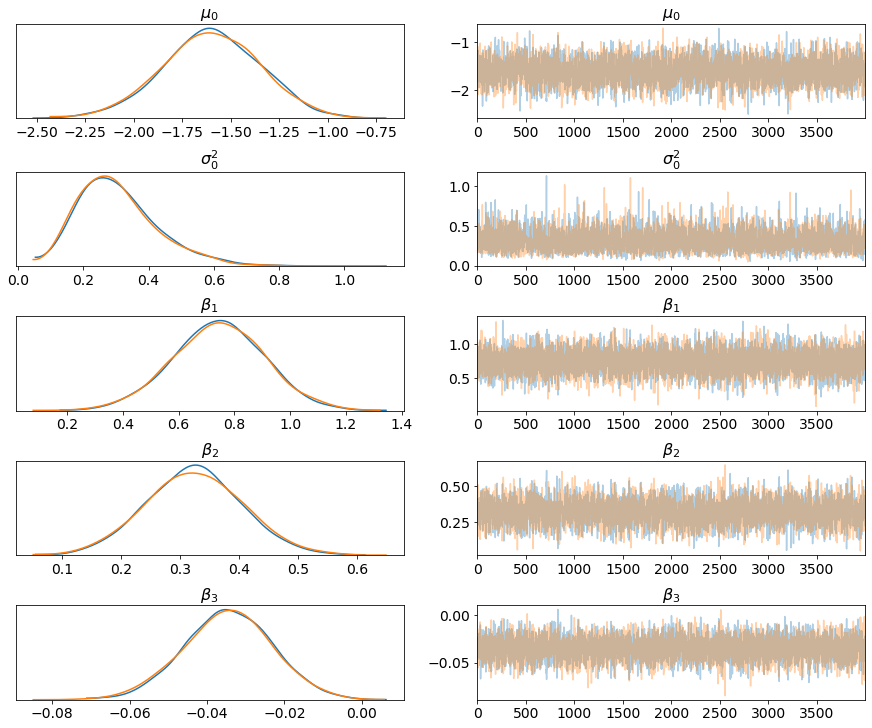

In [11]:
#your code here

import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)
    
    # plot the traceplot
    pm.traceplot(trace, 
                 var_names=['$\mu_0$', '$\sigma_0^{2}$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$'], 
                 compact=False)
    plt.show()

# Analysis

<div style="border: 1px solid red; padding: 10px"> 

Coefficient   |Recovered (posterior mean)|94% credible interval|$\hat{r}$
--------------|----------------|---------------------|-------
$\mu_0$       |-1.605          |-2.090 to -1.129     |1.0
$\sigma_0^{2}$|0.303           |0.104 to 0.538       |1.0
$\beta_1$     |0.740           |0.421 to 1.037       |1.0
$\beta_2$     |0.323           |0.166  to 0.478      |1.0
$\beta_3$     |-0.035          |-0.057 to -0.013     |1.0

***Observation on Convergence of Paramenters:***
* $\hat{r}$ value for all the parameters is equal to $1$.
* **From the visual inspection of the graph and the $\hat{r}$ values we can comfortably say that the samplers did converge.**
    
***Additional Comments:***
* True value of $\beta_3$ might be equal to $0$ or there might be non-linear relationship to $age\_mean$

##### **A8**

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

In [12]:
#your code here

# look for the districts with highest and lowest mean intercept
high = np.argmax(pm.summary(trace, var_names=['$\\beta_0$'])['mean'].to_numpy())
low = np.argmin(pm.summary(trace, var_names=['$\\beta_0$'])['mean'].to_numpy())

print('\nDistrict with the highest base rate of contraceptive usage is:\t\t{}'.format(high))
print('\nDistrict with the lowest base rate of contraceptive usage is:\t\t{}'.format(low))


District with the highest base rate of contraceptive usage is:		56

District with the lowest base rate of contraceptive usage is:		11


# Analysis

<div style="border: 1px solid red; padding: 10px"> 

***Comments on districts with the highest/lowest base rate of contraceptive usage (independent of other factors):***
* District with the highest value of $\beta_0$ will have the highest base rate of contraceptive usage
    - **District 56 has the highest base rate of contraceptive usage**
    
* District with the lowest value of $\beta_0$ will have the lowest base rate of contraceptive usage
    - **District 11 has the lowest base rate of contraceptive usage**

##### **A9**

What are the posterior means of $\mu_0$ and $\sigma^2_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts or a model with an intercept of 0 for all districts?

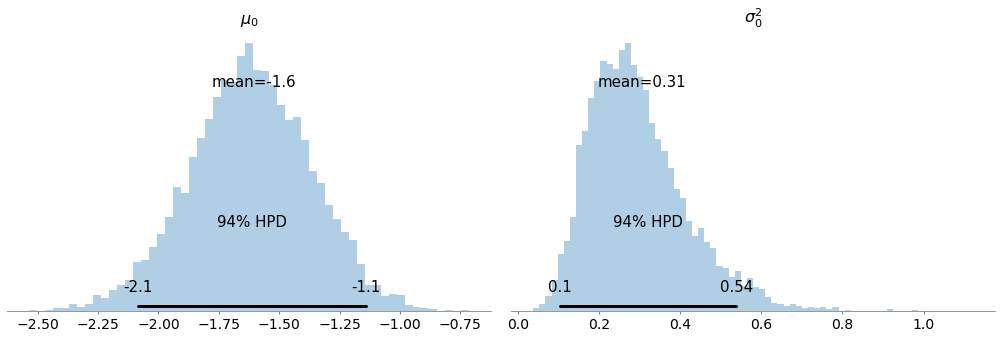

In [13]:
#your code here

# plot the posterior distributions of the mu and sigma_squared
pm.plots.plot_posterior(trace, 
                        var_names=['$\mu_0$', '$\sigma_0^{2}$'], kind='hist')
plt.show()

# Analysis

<div style="border: 1px solid red; padding: 10px"> 
    
Coefficient   |Posterior Mean  |94% Credible Interval|$\hat{r}$
--------------|----------------|---------------------|-------
$\mu_0$       |-1.6            |-2.1 to -1.1         |1.0
$\sigma_0^{2}$|0.3             |0.1   to 0.54        |1.0

***Evidence in support of or against the varying-intercept model:***
* Based on the $\mu_0$ credible interval of ```[-2.2   -1.1]``` we can say with ```94%``` probability that $\mu_0$ is not equal to ```0``` and lies in the above-mentioned interval
    - **This implies that itercept of ```0``` for all disctricts can be rejected**
* Based on the $\sigma_0^{2}$ credible interval of ```[0.1   0.54]``` we can say with ```94%``` probability that $\sigma_0^{2}$ is greater than ```0``` and lies in the above-mentioned interval
    - **This implies that we can reject constant itercept for all the districts and accept varying intervals**
    - **There is only ```3%``` probability that true $\sigma_0^{2}$ is less than ```0.1```**

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

##### **B1**

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [14]:
#your code here

# setting seed for replication
np.random.seed(109)

# MCMC Simulation
cores=4
model = pm.Model()
with model:
    # prior
    mu_0 = pm.Normal('$\mu_0$', mu=0, sd=100)
    sigma_0_sq = pm.InverseGamma('$\sigma_0^{2}$', 0.1, 0.1)
    z_0 = pm.Normal('z0', mu=0, sd=1, shape=j)
    beta_0 = pm.Deterministic('$\\beta_0$', mu_0 + z_0*(sigma_0_sq**0.5))
    
    sigma_1_sq = pm.InverseGamma('$\sigma_1^{2}$', 0.1, 0.1)
    z_1 = pm.Normal('z1', mu=0, sd=1, shape=j)
    beta_1 = pm.Deterministic('$\\beta_1$', z_1*(sigma_1_sq**0.5))
    
    sigma_2_sq = pm.InverseGamma('$\sigma_2^{2}$', 0.1, 0.1)
    z_2 = pm.Normal('z2', mu=0, sd=1, shape=j)
    beta_2 = pm.Deterministic('$\\beta_2$', z_2*(sigma_2_sq**0.5))
    
    sigma_3_sq = pm.InverseGamma('$\sigma_3^{2}$', 0.1, 0.1)
    z_3 = pm.Normal('z3', mu=0, sd=1, shape=j)
    beta_3 = pm.Deterministic('$\\beta_3$', z_3*(sigma_3_sq**0.5))
    
    # beta for the given district
    beta_0_j = beta_0[train['district'].values]
    beta_1_j = beta_1[train['district'].values]
    beta_2_j = beta_2[train['district'].values]
    beta_3_j = beta_3[train['district'].values]

    # likelihood
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit((beta_0_j) +
                                                     (beta_1_j * train['urban']) + 
                                                     (beta_2_j * train['living.children']) + 
                                                     (beta_3_j * train['age_mean'])
                                                    ))

    obs = pm.Bernoulli(name='c_use', p=p_i, observed=train['contraceptive_use'])
    trace = pm.sample(4000, tune=4000, target_accept=0.95, max_treedepth=100, cores=cores, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z3, $\sigma_3^{2}$, z2, $\sigma_2^{2}$, z1, $\sigma_1^{2}$, z0, $\sigma_0^{2}$, $\mu_0$]
Sampling 4 chains, 0 divergences: 100%|██████████| 32000/32000 [06:17<00:00, 84.82draws/s] 


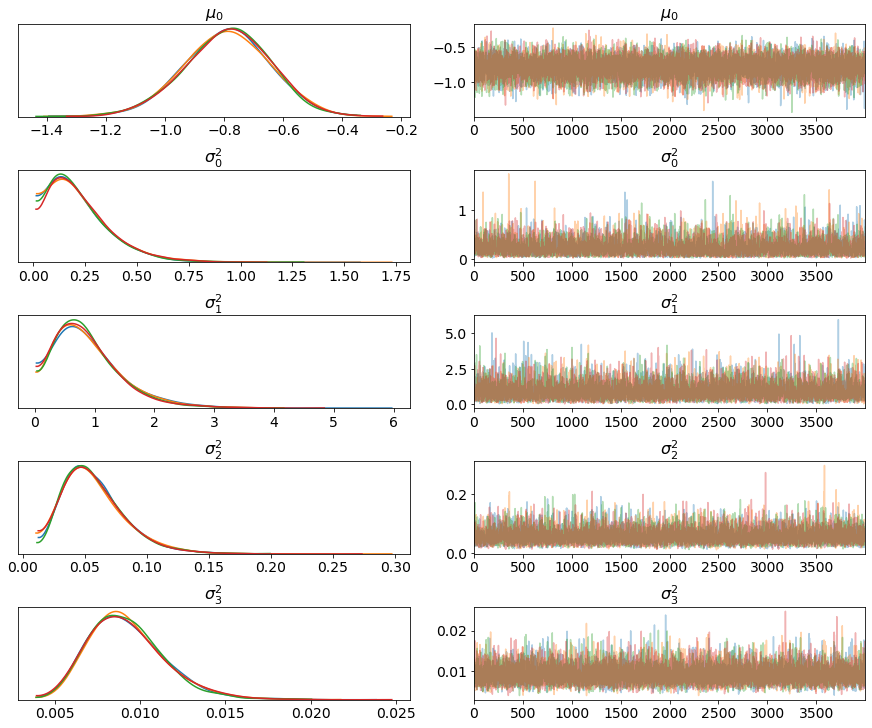

In [15]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)
    
    # plot the traceplot
    pm.traceplot(trace,
                 var_names=['$\mu_0$',
                            '$\sigma_0^{2}$', '$\sigma_1^{2}$', '$\sigma_2^{2}$', '$\sigma_3^{2}$'],
                 compact=False)
    plt.show()

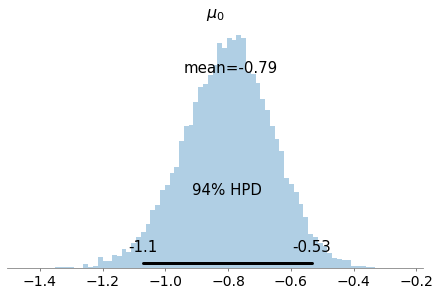

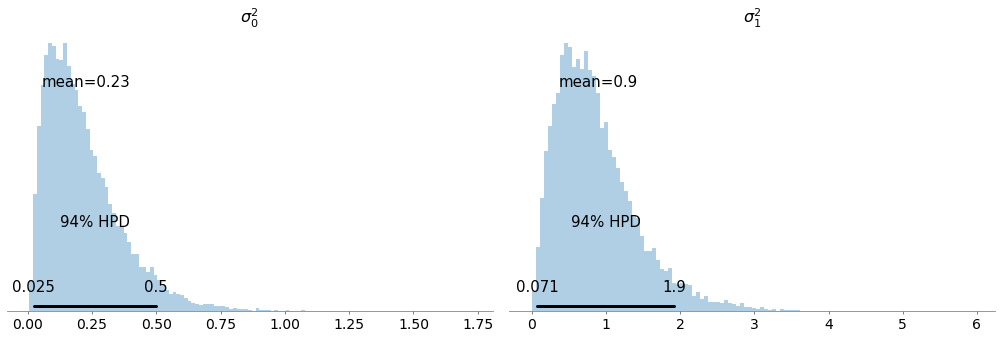

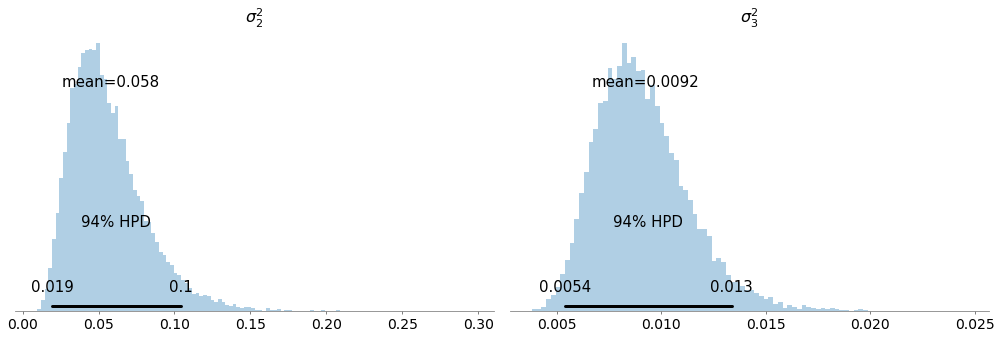

In [16]:
# plot the posterior distributions of the mu_0 and sigma_squared_i
pm.plots.plot_posterior(trace, 
                        var_names=['$\mu_0$'],
                        kind='hist')

pm.plots.plot_posterior(trace, 
                        var_names=['$\sigma_0^{2}$', '$\sigma_1^{2}$'],
                        kind='hist')

pm.plots.plot_posterior(trace, 
                        var_names=['$\sigma_2^{2}$', '$\sigma_3^{2}$'],
                        kind='hist')

plt.show()

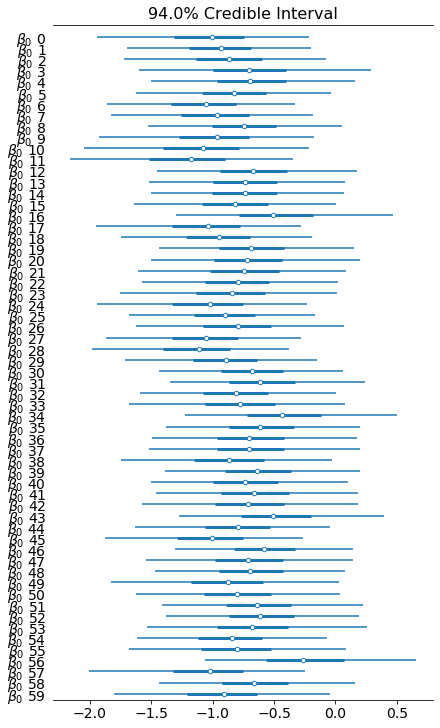

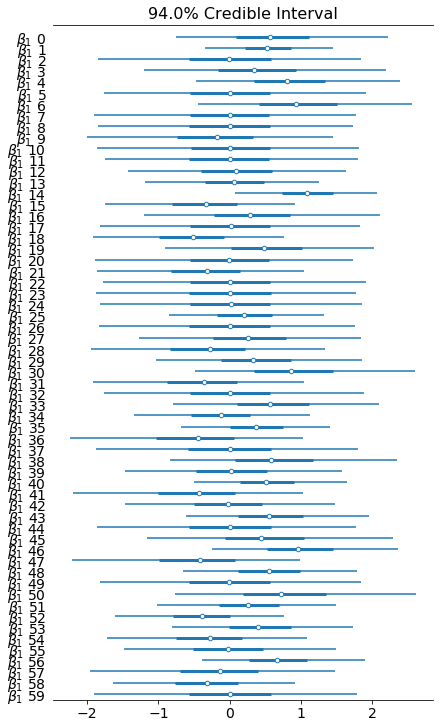

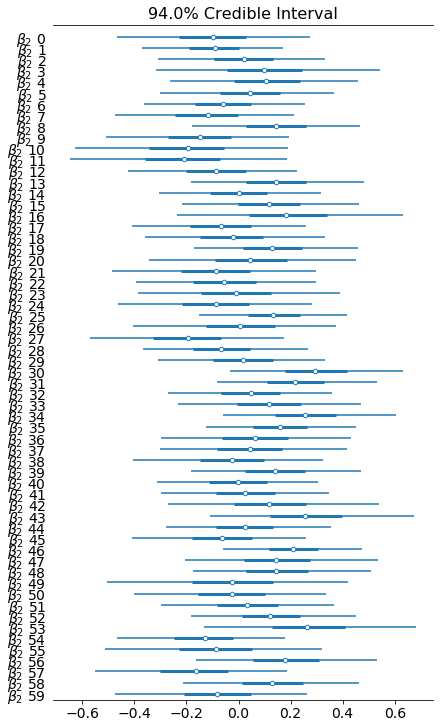

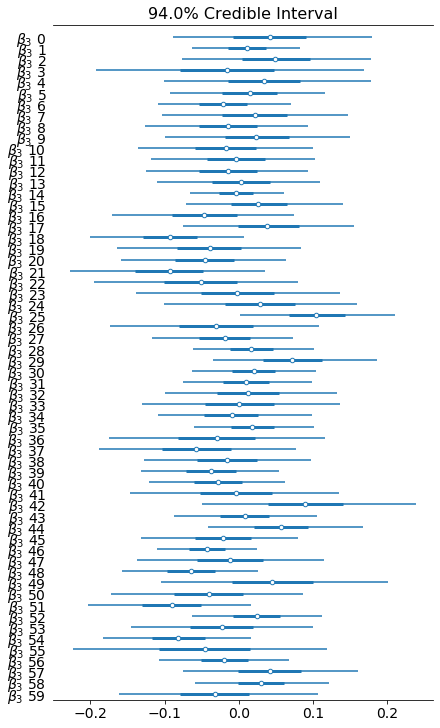

In [17]:
# forest plot of the Beta_i_j's
for x in ['$\\beta_0$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$']:
    pm.plot_forest(trace, var_names=[x], combined=True)

# Analysis

<div style="border: 1px solid red; padding: 10px"> 
       
***Observations from plots of posterior means for each of the coefficients to the predictors:***
* First we check from the traceplot that parameters did converge
* Visual inspection of the plots of posterior means of each of the $\beta_i$ reveals the following:
    - For any given $\beta_i$ the variation within different districts fall within a similar range and mostly overlapping range
    - Credible range of $\beta_i$ varies by district and in certain cases are non-overlapping as well
    - Credible range of $\sigma^2_i$ does not include zero
    - **Above observations are in line with out working hypothesis that for any given $i$, $\beta_i$ do vary by district but at the same time come from same distribution**
* **One observation to note is that $\sigma^2_i$, for $i$ in ${\{2,3\}}$, is very small number**
    - This may be because $\beta_i$, for $i = 2$ or $3$ or $both$, do not vary by district and model is just overfitting
    - $\beta_3$ could be equal to $0$ as discussed in A7

##### **B2**

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

# Approach

<div style="border: 1px solid red; padding: 10px"> 
    
***Validation based approach***
* We have reasonable evidence from our earlier analysis that $\beta_i$ vary by district
* We have some suspicion regarding $\beta_i$ for $i$ in $\{2,3\}$, being non-varying or being equal to zero
* We will follow the following approach:
    - Consider test set as validation set (**alternatively, set could be divided into 2 parts, validation set and test set - we are ignoring that for convenience sake**)
    - Simulate multiple models
    - Choose the model with best validation accuracy

***Models we will simulate***
1. All $\beta_i$ are varying
2. All $\beta_i$ are varying but drop $\beta_3$
3. $\beta_0$ and $\beta_1$ are varying but $\beta_2$ and $\beta_3$ are non varying
4. All $\beta_i$ are non-varying (**to determine if really simple model does a good job or not**)
5. $\beta_1$  is varying but all other $\beta_i$ are non-varying

In [18]:
def compute_accuracy():

    # decision cut-off for classificaiton prediction
    p_cutoff = 0.50

    # classify the data point based on the cut-off
    train['yhat'] = (train['p'] > p_cutoff)*1
    test['yhat'] = (test['p'] > p_cutoff)*1

    # compute the training and test prediction accuracy
    print("Training Accuracy = {}\n".format(np.sum(train['yhat'] == 
                                                   train['contraceptive_use'])/train['yhat'].count()))
    
    print("Validation Accuracy = {}\n".format(np.sum(test['yhat'] == 
                                                  test['contraceptive_use'])/test['yhat'].count()))

## Model 1: All $\beta_i$ are varying

***This is same as model above in B1***
* We will just compute Training and Test Accuracy

***We find that this model is most likely overfitting given the 8% difference betweeen Training and Validation Score***

In [19]:
# predict contraceptive use based on on posterior mean of beta's

# extract the beta's
beta = pm.summary(trace, var_names=['$\\beta_0$', '$\\beta_1$', 
                                    '$\\beta_2$', '$\\beta_3$'])['mean'].to_numpy().reshape(-1,60).T
beta0 = beta[:,0]
beta = beta[:,1:]

# compute the p_i
train['p'] = expit(np.sum(train[['urban','living.children','age_mean']] * beta[train.district,:],axis=1)+ 
                   beta0[train.district])

test['p'] = expit(np.sum(test[['urban','living.children','age_mean']] * beta[test.district,:],axis=1)+
                  beta0[test.district])

compute_accuracy()

Training Accuracy = 0.7021716649431231

Validation Accuracy = 0.6194415718717684



## Model 2: All $\beta_i$ are varying but drop $\beta_3$

***This model is an improvement over Model 1 - while training accuracy reduces, the validation score goes up***

In [20]:
#your code here

# setting seed for replication
np.random.seed(109)

# MCMC Simulation
model = pm.Model()
with model:
    # prior
    mu_0 = pm.Normal('$\mu_0$', mu=0, sd=100)
    sigma_0_sq = pm.InverseGamma('$\sigma_0^{2}$', 0.1, 0.1)
    z_0 = pm.Normal('z0', mu=0, sd=1, shape=j)
    beta_0 = pm.Deterministic('$\\beta_0$', mu_0 + z_0*(sigma_0_sq**0.5))
    
    sigma_1_sq = pm.InverseGamma('$\sigma_1^{2}$', 0.1, 0.1)
    z_1 = pm.Normal('z1', mu=0, sd=1, shape=j)
    beta_1 = pm.Deterministic('$\\beta_1$', z_1*(sigma_1_sq**0.5))
    
    sigma_2_sq = pm.InverseGamma('$\sigma_2^{2}$', 0.1, 0.1)
    z_2 = pm.Normal('z2', mu=0, sd=1, shape=j)
    beta_2 = pm.Deterministic('$\\beta_2$', z_2*(sigma_2_sq**0.5))
    
    # beta for the given district
    beta_0_j = beta_0[train['district'].values]
    beta_1_j = beta_1[train['district'].values]
    beta_2_j = beta_2[train['district'].values]

    # likelihood
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit((beta_0_j) +
                                                     (beta_1_j * train['urban']) + 
                                                     (beta_2_j * train['living.children'])
                                                    ))

    obs = pm.Bernoulli(name='c_use', p=p_i, observed=train['contraceptive_use'])
    trace = pm.sample(4000, tune=4000, target_accept=0.95, max_treedepth=100, cores=cores, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z2, $\sigma_2^{2}$, z1, $\sigma_1^{2}$, z0, $\sigma_0^{2}$, $\mu_0$]
Sampling 4 chains, 0 divergences: 100%|██████████| 32000/32000 [05:21<00:00, 99.63draws/s] 


In [21]:
# predict contraceptive use based on on posterior mean of beta's

# extract the beta's
beta = pm.summary(trace, var_names=['$\\beta_0$', 
                                    '$\\beta_1$', 
                                    '$\\beta_2$'])['mean'].to_numpy().reshape(-1,60).T
beta0 = beta[:,0]
beta = beta[:,1:]

# compute the p_i
train['p'] = expit(np.sum(train[['urban','living.children']] * beta[train.district,:],axis=1)+ 
                   beta0[train.district])

test['p'] = expit(np.sum(test[['urban','living.children']] * beta[test.district,:],axis=1)+
                  beta0[test.district])

compute_accuracy()

Training Accuracy = 0.6845915201654602

Validation Accuracy = 0.6339193381592554



## Model 3: $\beta_0$ and $\beta_1$ are varying but $\beta_2$ and $\beta_3$ are non varying

***This model is further improvement with both Training accuracy and validation score going up and the gap between the two further reducing***

In [22]:
#your code here

# setting seed for replication
np.random.seed(109)

# MCMC Simulation
model = pm.Model()
with model:
    # prior
    mu_0 = pm.Normal('$\mu_0$', mu=0, sd=100)
    sigma_0_sq = pm.InverseGamma('$\sigma_0^{2}$', 0.1, 0.1)
    z_0 = pm.Normal('z0', mu=0, sd=1, shape=j)
    beta_0 = pm.Deterministic('$\\beta_0$', mu_0 + z_0*(sigma_0_sq**0.5))
    
    sigma_1_sq = pm.InverseGamma('$\sigma_1^{2}$', 0.1, 0.1)
    z_1 = pm.Normal('z1', mu=0, sd=1, shape=j)
    beta_1 = pm.Deterministic('$\\beta_1$', z_1*(sigma_1_sq**0.5))
    
    beta_2 = pm.Normal('$\\beta_2$', mu=0, sd=100)
    beta_3 = pm.Normal('$\\beta_3$', mu=0, sd=100)
    
    # beta for the given district
    beta_0_j = beta_0[train['district'].values]
    beta_1_j = beta_1[train['district'].values]

    # likelihood
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit((beta_0_j) +
                                                     (beta_1_j * train['urban']) + 
                                                     (beta_2 * train['living.children']) + 
                                                     (beta_3 * train['age_mean'])
                                                    ))

    obs = pm.Bernoulli(name='c_use', p=p_i, observed=train['contraceptive_use'])
    trace = pm.sample(4000, tune=4000, target_accept=0.95, max_treedepth=100, cores=cores, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\beta_3$, $\beta_2$, z1, $\sigma_1^{2}$, z0, $\sigma_0^{2}$, $\mu_0$]
Sampling 4 chains, 0 divergences: 100%|██████████| 32000/32000 [06:08<00:00, 86.93draws/s] 


In [23]:
# predict contraceptive use based on on posterior mean of beta's

# extract the beta's
beta = pm.summary(trace, var_names=['$\\beta_0$', '$\\beta_1$', 
                                    '$\\beta_2$', '$\\beta_3$'])['mean'].to_numpy().reshape(-1,1)
beta0 = beta[:j]
beta1 = beta[j:2*j]
beta = beta[2*j:].reshape(-1,1)

# compute the p_i
train['p'] = expit(train['urban'].to_numpy().reshape(-1,1) * beta1[train.district] + 
                   train[['living.children', 'age_mean']] @ beta +
                   beta0[train.district,:])

test['p'] = expit(test['urban'].to_numpy().reshape(-1,1) * beta1[test.district] +
                  test[['living.children', 'age_mean']] @ beta +
                  beta0[test.district,:])

compute_accuracy()

Training Accuracy = 0.6907962771458118

Validation Accuracy = 0.6463288521199586



## Model 4: All $\beta_i$ are non-varying

***With Validation score higher than the Training accuracy, this model is most likely underfitting the data***

In [24]:
#your code here

# setting seed for replication
np.random.seed(109)

# MCMC Simulation
model = pm.Model()
with model:
    # prior
    beta_0 = pm.Normal('$\\beta_0$', mu=0, sd=100)
    beta_1 = pm.Normal('$\\beta_1$', mu=0, sd=100)
    beta_2 = pm.Normal('$\\beta_2$', mu=0, sd=100)
    beta_3 = pm.Normal('$\\beta_3$', mu=0, sd=100)

    # likelihood
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit((beta_0) +
                                                     (beta_1 * train['urban']) + 
                                                     (beta_2 * train['living.children']) + 
                                                     (beta_3 * train['age_mean'])
                                                    ))

    obs = pm.Bernoulli(name='c_use', p=p_i, observed=train['contraceptive_use'])
    trace = pm.sample(4000, tune=4000, target_accept=0.9, max_treedepth=100, cores=cores, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\beta_3$, $\beta_2$, $\beta_1$, $\beta_0$]
Sampling 4 chains, 0 divergences: 100%|██████████| 32000/32000 [02:18<00:00, 231.49draws/s]


In [25]:
# predict contraceptive use based on on posterior mean of beta's

# extract the beta's
beta = pm.summary(trace, var_names=['$\\beta_0$', '$\\beta_1$', 
                                    '$\\beta_2$', '$\\beta_3$'])['mean'].to_numpy().reshape(-1,1)

# compute the p_i
train['p'] = expit(train[['urban', 'living.children', 'age_mean']] @ beta[1:,0] + beta[0,0])
test['p'] = expit(test[['urban', 'living.children', 'age_mean']] @ beta[1:,0] + beta[0,0])

compute_accuracy()

Training Accuracy = 0.6215098241985523

Validation Accuracy = 0.6442605997931747



## Model 5: $\beta_1$  is varying but all other $\beta_i$ are non-varying

***This model achieves the best performance among all we test - While Trainign accuracy is lower than the Model 3, the validation score is higher bringing the gap between the two to its lowest level of 2% approximately***

In [26]:
#your code here

# setting seed for replication
np.random.seed(109)

# MCMC Simulation
model = pm.Model()
with model:
    # prior
    mu_0 = pm.Normal('$\mu_0$', mu=0, sd=100)
    sigma_0_sq = pm.InverseGamma('$\sigma_0^{2}$', 0.1, 0.1)
    z_0 = pm.Normal('z0', mu=0, sd=1, shape=j)
    beta_0 = pm.Deterministic('$\\beta_0$', mu_0 + z_0*(sigma_0_sq**0.5))
    
    beta_1 = pm.Normal('$\\beta_1$', mu=0, sd=100)
    beta_2 = pm.Normal('$\\beta_2$', mu=0, sd=100)
    beta_3 = pm.Normal('$\\beta_3$', mu=0, sd=100)

    # alpha  for the given district
    alpha = beta_0[train['district'].values]
    
    # likelihood
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(alpha +
                                                     (beta_1 * train['urban']) + 
                                                     (beta_2 * train['living.children']) + 
                                                     (beta_3 * train['age_mean'])
                                                    ))

    obs = pm.Bernoulli(name='c_use', p=p_i, observed=train['contraceptive_use'])
    trace = pm.sample(4000, tune=4000, target_accept=0.9, chains=4, cores=cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\beta_3$, $\beta_2$, $\beta_1$, z0, $\sigma_0^{2}$, $\mu_0$]
Sampling 4 chains, 0 divergences: 100%|██████████| 32000/32000 [03:22<00:00, 158.09draws/s]


In [27]:
# display the trace summary
display(pm.summary(trace, 
                   var_names=['$\mu_0$', '$\sigma_0^{2}$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$']))

display(pm.summary(trace, 
                   var_names=['$\\beta_0$']))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
$\mu_0$,-1.608,0.256,-2.103,-1.148,0.003,0.002,7150.0,7147.0,7157.0,10195.0,1.0
$\sigma_0^{2}$,0.305,0.122,0.099,0.532,0.001,0.001,7098.0,7098.0,6805.0,9503.0,1.0
$\beta_1$,0.738,0.163,0.428,1.040,0.001,0.001,17240.0,16941.0,17267.0,12223.0,1.0
$\beta_2$,0.324,0.082,0.169,0.479,0.001,0.001,7787.0,7787.0,7795.0,10960.0,1.0
$\beta_3$,-0.035,0.011,-0.057,-0.015,0.000,0.000,9329.0,9329.0,9338.0,12156.0,1.0


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
$\beta_0$[0],-2.073,0.491,-2.983,-1.136,0.004,0.003,13100.0,12943.0,13087.0,11831.0,1.0
$\beta_0$[1],-2.129,0.373,-2.842,-1.440,0.004,0.003,10996.0,10996.0,10992.0,11826.0,1.0
$\beta_0$[2],-1.780,0.490,-2.732,-0.884,0.004,0.003,13609.0,13299.0,13581.0,11111.0,1.0
$\beta_0$[3],-1.501,0.598,-2.640,-0.363,0.005,0.003,17067.0,16001.0,17182.0,11177.0,1.0
$\beta_0$[4],-1.441,0.474,-2.352,-0.561,0.004,0.003,15091.0,14620.0,15104.0,11985.0,1.0
$\beta_0$[5],-1.601,0.466,-2.457,-0.698,0.004,0.003,15730.0,15068.0,15741.0,12838.0,1.0
$\beta_0$[6],-1.972,0.404,-2.699,-1.184,0.003,0.002,14652.0,14538.0,14579.0,12239.0,1.0
$\beta_0$[7],-2.015,0.491,-2.962,-1.116,0.004,0.003,14283.0,13812.0,14333.0,12504.0,1.0
$\beta_0$[8],-1.384,0.441,-2.181,-0.525,0.004,0.003,15207.0,14449.0,15245.0,12590.0,1.0
$\beta_0$[9],-2.071,0.529,-3.058,-1.078,0.005,0.003,13674.0,13207.0,13726.0,12539.0,1.0


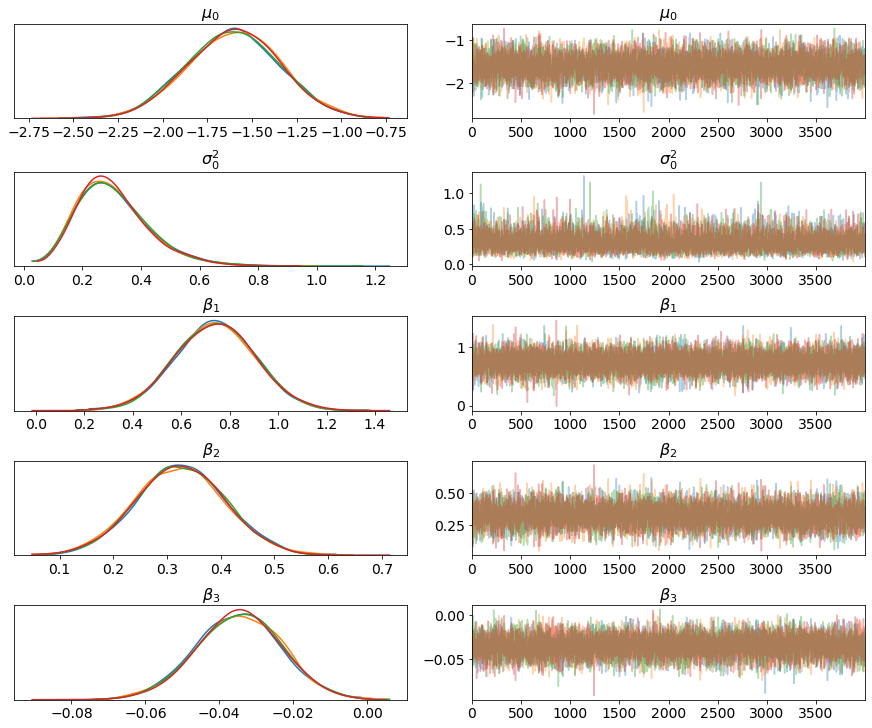

In [28]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)
    
    # plot the traceplot
    pm.traceplot(trace,
                 var_names=['$\mu_0$', '$\sigma_0^{2}$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$'],
                 compact=False)
    plt.show()

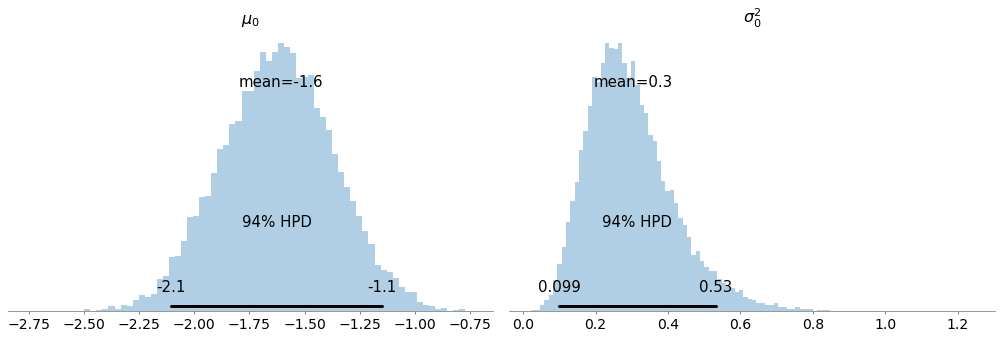

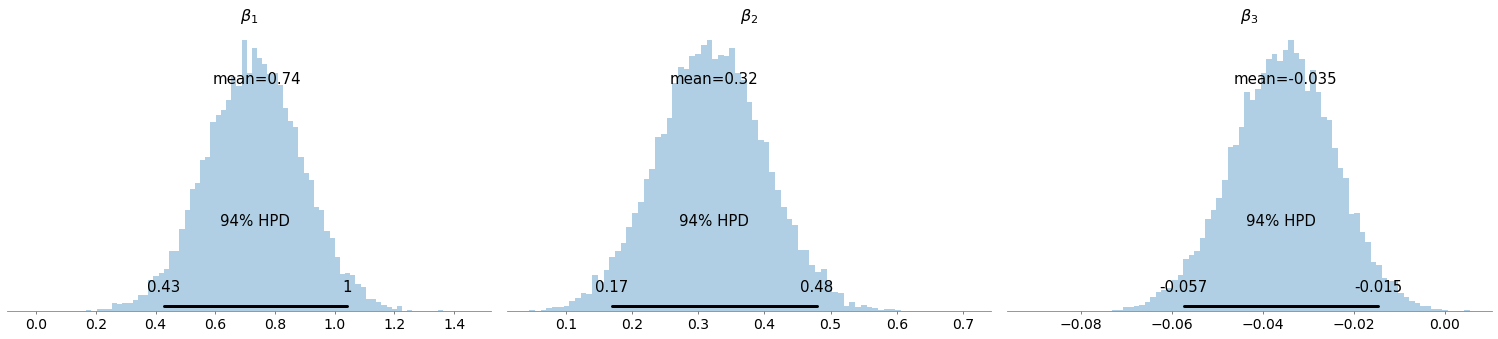

In [29]:
# plot the posterior distributions of the beta's
pm.plots.plot_posterior(trace, 
                        var_names=['$\mu_0$', '$\sigma_0^{2}$'],
                        kind='hist')
plt.show()


pm.plots.plot_posterior(trace, 
                        var_names=['$\\beta_1$', '$\\beta_2$', '$\\beta_3$'],
                        kind='hist')
plt.show()

In [30]:
# predict contraceptive use based on on posterior mean of beta's

# extract the beta's
beta3 = pm.summary(trace, var_names=['$\\beta_0$', '$\\beta_1$', 
                                     '$\\beta_2$', '$\\beta_3$'])['mean'].to_numpy().reshape(-1,1)

# compute the p_i
train['p'] = expit(train[['urban', 'living.children', 'age_mean']] @ beta3[j:,:] + beta3[train.district,:])
test['p'] = expit(test[['urban', 'living.children', 'age_mean']] @ beta3[j:,:] + beta3[test.district,:])

compute_accuracy()

Training Accuracy = 0.6742502585315409

Validation Accuracy = 0.655635987590486



In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion Matrix - Training
[[512  78]
 [237 140]]
Normalized confusion matrix
[[0.86779661 0.13220339]
 [0.62864721 0.37135279]]


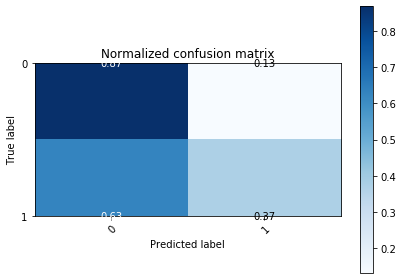

In [32]:
print("Confusion Matrix - Training")
print(confusion_matrix(train.contraceptive_use, train['yhat']))
plot_confusion_matrix(train.contraceptive_use, 
                      train['yhat'],
                      normalize=True,
                      title=None,
                      cmap=plt.cm.Blues)
plt.show()

Confusion Matrix - Testing
[[509  76]
 [257 125]]
Normalized confusion matrix
[[0.87008547 0.12991453]
 [0.67277487 0.32722513]]


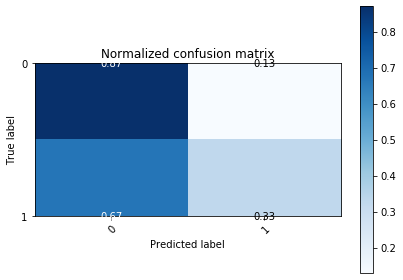

In [33]:
print("Confusion Matrix - Testing")
print(confusion_matrix(test.contraceptive_use, test['yhat']))
plot_confusion_matrix(test.contraceptive_use, 
                      test['yhat'],
                      normalize=True,
                      title=None,
                      cmap=plt.cm.Blues)
plt.show()

In [34]:
# predict contraceptive use based on on posterior distribution of beta's

# simulate the sample beta's from the posterior distribution
beta = list(pm.sample_posterior_predictive(trace,
                                           var_names=['$\\beta_0$', '$\\beta_1$', 
                                                      '$\\beta_2$', '$\\beta_3$'],
                                           samples=5000,
                                           model=model).values())

beta0 = np.array(beta[0].T)
beta = np.array(beta[1:])


# compute the average p_i using simulated betas
train['p'] = np.random.binomial(1, 
                                expit(train[['urban', 'living.children', 
                                             'age_mean']] @ beta +
                                      beta0[train.district,:])).mean(axis=1)
test['p'] = np.random.binomial(1, 
                               expit(test[['urban', 'living.children', 
                                           'age_mean']] @ beta + 
                                     beta0[test.district,:])).mean(axis=1)

compute_accuracy()

/usr/share/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 5000/5000 [00:02<00:00, 1710.75it/s]


Training Accuracy = 0.6763185108583247

Validation Accuracy = 0.6525336091003102



Confusion Matrix - Training
[[515  75]
 [238 139]]
Normalized confusion matrix
[[0.87288136 0.12711864]
 [0.63129973 0.36870027]]


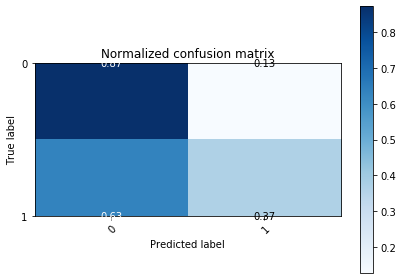

In [35]:
print("Confusion Matrix - Training")
print(confusion_matrix(train.contraceptive_use, train['yhat']))
plot_confusion_matrix(train.contraceptive_use, 
                      train['yhat'],
                      normalize=True,
                      title=None,
                      cmap=plt.cm.Blues)
plt.show()

Confusion Matrix - Testing
[[511  74]
 [262 120]]
Normalized confusion matrix
[[0.87350427 0.12649573]
 [0.68586387 0.31413613]]


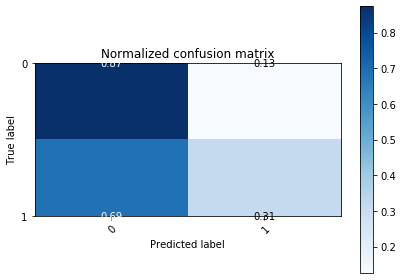

In [36]:
print("Confusion Matrix - Testing")
print(confusion_matrix(test.contraceptive_use, test['yhat']))
plot_confusion_matrix(test.contraceptive_use, 
                      test['yhat'],
                      normalize=True,
                      title=None,
                      cmap=plt.cm.Blues)
plt.show()

# Analysis

<div style="border: 1px solid red; padding: 10px"> 
    
## Summary of the Models
    
Model|Description|Training Accuracy|Validation Accuracy|Gap|Remarks
-|-|-|-|-|-
1|All $\beta_i$ are varying|70.22%|62.25%|7.97%|Over-fitting
2|All $\beta_i$ are varying but drop $\beta_3$|68.46%|63.39%|5.07%|Somewhat Over-fitting
3|$\beta_0$ and $\beta_1$ are varying but $\beta_2$ and $\beta_3$ are non varying|69.08%|64.63%|4.45%|Good-fit
4|All $\beta_i$ are non-varying|62.15%|64.53%|-2.38%|Under-fitting
**5**|**$\beta_1$ is varying but all other $\beta_i$ are non-varying**|**67.53%**|**65.46%**|**2.07%**|**Best-Fit**
    
***We pick Model 5 based on the highest validation score and lowest gap between training and validation accuracy***
* We have used Test set as validation set - ideally there should be seperate validation set or test set should be divided into validation and test set; we have ignored the same for convenience purposes

<div style="border: 1px solid red; padding: 10px"> 
    
## Selected Model: $\beta_1$ is varying but all other $\beta_i$ are non-varying (Model 5)
    
The final model we will fit to the contraceptives data is a **varying-intercept** but **non-varying-coefficients** logistic regression model, where the **$intercept$ varies by district** but the **slope coefficients on $urban$, $living.children$, and $age\_mean$, do not vary by district**.

### Model for coefficients:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$

$\beta_{1} \sim N(0,10000)$

$\beta_{2}\sim N(0,10000)$

$\beta_{3} \sim N(0,10000)$

### Model for data:

$Y_{i,j} \sim \text{Bernoulli}(p_{i,j})$

$\text{logit}\:p_{i,j} = \beta_{0,j} + \beta_{1} \times \text{urban} + \beta_{2} \times \text{living.children} + \beta_{3} \times \text{age_mean}$

### Recovered Parameters
Coefficient   |Recovered (posterior mean)|94% credible interval|$\hat{r}$
--------------|----------------|---------------------|-------
$\mu_0$       |-1.604          |-2.075 to -1.130     |1.0
$\sigma_0^{2}$|0.304           |0.109 to 0.545       |1.0
$\beta_1$     |0.738           |0.425 to 1.042       |1.0
$\beta_2$     |0.323           |0.170  to 0.479      |1.0
$\beta_3$     |-0.035          |-0.057 to -0.014     |1.0

### Reasoning behind the model
* We pick Model 5 based on the highest validation score and lowest gap between training and validation accuracy
    
### Performance of the model
* ***Training Accuracy =*** ```67.53% approx```
* ***Testing Accuracy =*** ```65.46% approx```
    
### Performance of the model using entire posterior distribution
* ***Training Accuracy =*** ```67.43% approx```
* ***Testing Accuracy =*** ```65.87% approx```
    
### Confusion Matrix - see cell below
* Our model does a better job of predicting correctly for women who are not using contraceptives
    - 88% accurate for women who are not using contraceptive
    - Only 33% accurate for women who are using contraceptive
    - When model predicts that a certain women does not use contraceptive, it is likely to correct about 66.58% of the time, assuming the ration of women using contraceptive versus not using contraceptive is same as that in test data. IF we assume both cases are equally likely, then this likelihood falls to 56.77%
    - When model predicts that a certain women does use contraceptive, it is likely to correct about 36.87% of the time, assuming the ration of women using contraceptive versus not using contraceptive is same as that in test data. IF we assume both cases are equally likely, then this likelihood falls to 26.67%

Normalized confusion matrix
[[0.87350427 0.12649573]
 [0.68586387 0.31413613]]


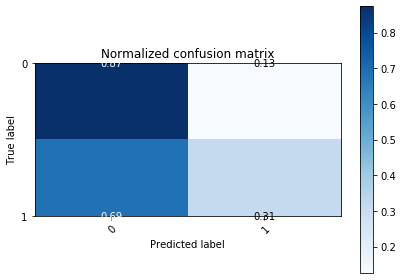

In [37]:
plot_confusion_matrix(test.contraceptive_use, 
                      test['yhat'],
                      normalize=True,
                      title=None,
                      cmap=plt.cm.Blues)
plt.show()

# End of Assignment